In [69]:
from google.colab import drive
drive.mount('/content/drive')
import os, sys
os.chdir('/content/drive/My Drive/capstone')
sys.path.insert(0, os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
import pandas as pd
from src.train import *
from src.model import CNNLSTMModel

from src.dataset_metadata import *
from src.preprocess import *
from src.visualize import *
import torch

## Hyper-Parameter

In [71]:
performe_visualization = False

In [72]:
# some important parameters
pre_day = 5

feature_cols = [
    "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED",  # ambient temperature
    "metric.STATUS_INTERNAL_TEMP.MEASURED",          # internal temperature
    "metric.AC_VOLTAGE_AB.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_BC.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_CA.MEASURED",                 # AC voltage
    "metric.DC_VOLTAGE.MEASURED",                  # DC voltage
    "metric.AC_POWER.MEASURED",                     # AC power
]

exclude_periods = [
    [pd.Timestamp('2021-01-01'), pd.Timestamp('2021-12-23')], # data collection issue
    [pd.Timestamp('2023-02-23'), pd.Timestamp('2023-08-26')], # anomalies in the data
]

## Data Preprocessing


### Load Data

In [73]:
inverter_data = load_parquet_data('data/inverter_data')
failure_sessions = load_failure_sessions('data/failure_sessions_w_maintenance.csv', min_days=3)

Loaded 15 parquet files → 6126272 rows
Kept 61 sessions longer than 3 days


In [74]:
visualize_failure_timeline(failure_sessions)

In [75]:
if performe_visualization:
    # Visualize the raw data
    visualize_mean_values(inverter_data, failure_sessions, feature_cols, 'visualization', 'raw_data')

In [76]:
# remove unused columns
filtered_data = inverter_data[['event_local_time', 'device_name'] + feature_cols].copy()

### Anomoly Detection

In [77]:
if "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED" in filtered_data.columns:
    anomaly_ids = filtered_data["metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"]>=100
    filtered_data.loc[anomaly_ids, "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"] = None
    print("Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed:", anomaly_ids.sum())

Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed: 244163


### Missing Value Imputation

In [78]:
imputed_df = missing_value_imputation(
    filtered_data, feature_cols,
    time_col='event_local_time',
    device_col='device_name',
    short_gap_limit=0,
    long_fill_value=0.0,
    add_missing_mask=True
    )
extended_feature_cols = feature_cols+[col+'_missing' for col in feature_cols]

### Downsampling

In [79]:
downsampled_data = downsample_inverter_raw(imputed_df, drop_empty_bins=False)
downsampled_data.dropna(inplace=True) # NaN will be generated by downsampling, so we drop them

Downsampling 6126272 rows using following method: 
                                               Column Aggregation
0                       metric.AC_VOLTAGE_AB.MEASURED        mean
1                       metric.AC_VOLTAGE_BC.MEASURED        mean
2                       metric.AC_VOLTAGE_CA.MEASURED        mean
3                          metric.DC_VOLTAGE.MEASURED        mean
4                            metric.AC_POWER.MEASURED        mean
5               metric.AC_VOLTAGE_AB.MEASURED_missing        mean
6               metric.AC_VOLTAGE_BC.MEASURED_missing        mean
7               metric.AC_VOLTAGE_CA.MEASURED_missing        mean
8                  metric.DC_VOLTAGE.MEASURED_missing        mean
9                    metric.AC_POWER.MEASURED_missing        mean
10       metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED         max
11               metric.STATUS_INTERNAL_TEMP.MEASURED         max
12  metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED_m...        mean
13       metric.STATUS_IN

/content/drive/My Drive/capstone/src/preprocess.py:308: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/content/drive/My Drive/capstone/src/preprocess.py:308: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/content/drive/My Drive/capstone/src/preprocess.py:308: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/content/drive/My Drive/capstone/src/preprocess.py:308: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/content/drive/My Drive/capstone/src/preprocess.py:308: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/content/drive/My Drive/capstone/src/preprocess.py:308: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/content/drive/My Drive/capstone/src/preprocess.py:3

In [80]:
if performe_visualization:
    # Visualize the downsampled data
    visualize_mean_values(
        downsampled_data,
        failure_sessions,
        extended_feature_cols,
        'visualization',
        'downsampled_data',
        freq=None
    )

### Data Cleaning

In [81]:
print("failure_sessions shape:", failure_sessions.shape)
failure_sessions['event_local_time'] = failure_sessions['start_time']
filtered_sessions = exclude_periods_from_data(failure_sessions, exclude_periods)
filtered_sessions['event_local_time'] = filtered_sessions['end_time']
filtered_sessions = exclude_periods_from_data(filtered_sessions, exclude_periods)
print("failure_sessions shape:", filtered_sessions .shape)

failure_sessions shape: (61, 6)
Excluded 2 periods, remaining data size: 47
Excluded 2 periods, remaining data size: 47
failure_sessions shape: (47, 7)


In [82]:
visualize_failure_timeline(filtered_sessions)

In [83]:
print("inverter_data shape:", downsampled_data.shape)
downsampled_data = exclude_periods_from_data(downsampled_data, exclude_periods)
print("Excluded data shape:", downsampled_data.shape)

inverter_data shape: (1021056, 16)
Excluded 2 periods, remaining data size: 862112
Excluded data shape: (862112, 16)


### Data Labeling

In [84]:
downsampled_data = prepare_dataset(downsampled_data, failure_sessions, pre_days=pre_day)

Total pre-failure rows: 5584
Total rows: 837811


### Feature Engineering

In [85]:
# month_of_year 範圍 1~12
downsampled_data['month_sin'] = np.sin(2 * np.pi * downsampled_data['event_local_time'].dt.month / 12)
downsampled_data['month_cos'] = np.cos(2 * np.pi * downsampled_data['event_local_time'].dt.month / 12)

# 如果還有 hour_of_day (0~23) 也可以同理轉
downsampled_data['hour_sin'] = np.sin(2 * np.pi * downsampled_data['event_local_time'].dt.hour / 24)
downsampled_data['hour_cos'] = np.cos(2 * np.pi * downsampled_data['event_local_time'].dt.hour / 24)

extended_feature_cols += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']

In [86]:
v = downsampled_data[['metric.AC_VOLTAGE_AB.MEASURED','metric.AC_VOLTAGE_BC.MEASURED','metric.AC_VOLTAGE_CA.MEASURED']]
v_mean = v.mean(axis=1)
v_range = v.max(axis=1) - v.min(axis=1)
downsampled_data['V_mean'] = v_mean
downsampled_data['V_unbalance'] = v_range / (v_mean + 1e-6)

extended_feature_cols += ['V_mean', 'V_unbalance']

In [87]:
downsampled_data

,event_local_time,device_name,metric.AC_VOLTAGE_AB.MEASURED,metric.AC_VOLTAGE_BC.MEASURED,metric.AC_VOLTAGE_CA.MEASURED,metric.DC_VOLTAGE.MEASURED,metric.AC_POWER.MEASURED,metric.AC_VOLTAGE_AB.MEASURED_missing,metric.AC_VOLTAGE_BC.MEASURED_missing,metric.AC_VOLTAGE_CA.MEASURED_missing,...,metric.STATUS_INTERNAL_TEMP.MEASURED,metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED_missing,metric.STATUS_INTERNAL_TEMP.MEASURED_missing,label,month_sin,month_cos,hour_sin,hour_cos,V_mean,V_unbalance
0,2021-12-24 00:00:00,INV 51,34400.171875,34400.000000,34400.000000,12.439572,0.0,0.0,0.0,0.0,...,40.000000,0.0,0.0,0,-2.449294e-16,1.000000,0.000000,1.000000,34400.058594,0.000005
1,2021-12-24 00:30:00,INV 51,34186.058594,34185.386719,34185.386719,41.699497,0.0,0.0,0.0,0.0,...,40.000000,0.0,0.0,0,-2.449294e-16,1.000000,0.000000,1.000000,34185.609375,0.000020
2,2021-12-24 01:00:00,INV 51,34186.824219,34186.449219,34186.449219,3.771897,0.0,0.0,0.0,0.0,...,41.000000,0.0,0.0,0,-2.449294e-16,1.000000,0.258819,0.965926,34186.574219,0.000011
3,2021-12-24 01:30:00,INV 51,34367.199219,34367.480469,34367.480469,4.273490,0.0,0.0,0.0,0.0,...,42.000000,0.0,0.0,0,-2.449294e-16,1.000000,0.258819,0.965926,34367.386719,0.000008
4,2021-12-24 02:00:00,INV 51,34101.886719,34101.933594,34101.933594,29.879051,0.0,0.0,0.0,0.0,...,42.036221,0.0,0.0,0,-2.449294e-16,1.000000,0.500000,0.866025,34101.917969,0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837806,2025-07-23 21:30:00,INV 66,34283.332031,34283.332031,34283.332031,2.183333,0.0,0.0,0.0,0.0,...,44.000000,0.0,0.0,0,-5.000000e-01,-0.866025,-0.707107,0.707107,34283.332031,0.000000
837807,2025-07-23 22:00:00,INV 66,34200.000000,34200.000000,34200.000000,2.037213,0.0,0.0,0.0,0.0,...,43.000000,0.0,0.0,0,-5.000000e-01,-0.866025,-0.500000,0.866025,34200.000000,0.000000
837808,2025-07-23 22:30:00,INV 66,34300.746094,34300.746094,34300.746094,2.100000,0.0,0.0,0.0,0.0,...,41.000000,0.0,0.0,0,-5.000000e-01,-0.866025,-0.500000,0.866025,34300.746094,0.000000
837809,2025-07-23 23:00:00,INV 66,34516.667969,34516.667969,34516.667969,2.263698,0.0,0.0,0.0,0.0,...,40.000000,0.0,0.0,0,-5.000000e-01,-0.866025,-0.258819,0.965926,34516.667969,0.000000


In [88]:
downsampled_data['T_delta'] = downsampled_data['metric.STATUS_INTERNAL_TEMP.MEASURED'] - downsampled_data['metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED']
extended_feature_cols += ['T_delta']

In [89]:
if performe_visualization:
    visualize_mean_values(downsampled_data, failure_sessions, extended_feature_cols+['label'],
                                title='processed_data', freq=None)

### Split Dataset

In [90]:
split_time = [pd.Timestamp('2024-01-03'), pd.Timestamp('2024-07-01')]


train_df = downsampled_data[downsampled_data['event_local_time'] <= split_time[0]].copy()
val_df = downsampled_data[(downsampled_data['event_local_time'] > split_time[0]) & (downsampled_data['event_local_time'] <= split_time[1])].copy()
test_df = downsampled_data[downsampled_data['event_local_time'] > split_time[1]].copy()

In [91]:
print('train set period:', train_df['event_local_time'].min(), train_df['event_local_time'].max())
print('validation set period:', val_df['event_local_time'].min(), val_df['event_local_time'].max())
print('test set period:', test_df['event_local_time'].min(), test_df['event_local_time'].max())

train set period: 2021-12-24 00:00:00 2024-01-03 00:00:00
validation set period: 2024-01-03 00:30:00 2024-07-01 00:00:00
test set period: 2024-07-01 00:30:00 2025-07-23 23:30:00


In [92]:
extended_feature_cols

['metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED',
 'metric.STATUS_INTERNAL_TEMP.MEASURED',
 'metric.AC_VOLTAGE_AB.MEASURED',
 'metric.AC_VOLTAGE_BC.MEASURED',
 'metric.AC_VOLTAGE_CA.MEASURED',
 'metric.DC_VOLTAGE.MEASURED',
 'metric.AC_POWER.MEASURED',
 'metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED_missing',
 'metric.STATUS_INTERNAL_TEMP.MEASURED_missing',
 'metric.AC_VOLTAGE_AB.MEASURED_missing',
 'metric.AC_VOLTAGE_BC.MEASURED_missing',
 'metric.AC_VOLTAGE_CA.MEASURED_missing',
 'metric.DC_VOLTAGE.MEASURED_missing',
 'metric.AC_POWER.MEASURED_missing',
 'hour_sin',
 'hour_cos',
 'month_sin',
 'month_cos',
 'V_mean',
 'V_unbalance',
 'T_delta']

### Standardization

In [93]:
from scipy.stats import f_oneway

def anova_test(df, feature, device_col='device_name'):
    groups = [df[df[device_col] == d][feature].dropna()
              for d in df[device_col].unique()]
    stat, p = f_oneway(*groups)
    return stat, p
anova_results = {col: anova_test(train_df, col) for col in extended_feature_cols}

In [94]:
anova_results_df = pd.DataFrame(anova_results, index=['F-statistic', 'p-value']).T
anova_results_df.sort_values(by='p-value', inplace=True)
anova_results_df

,F-statistic,p-value
metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED,98.680946,0.000000e+00
metric.STATUS_INTERNAL_TEMP.MEASURED,114.407997,0.000000e+00
metric.AC_VOLTAGE_AB.MEASURED,31.448612,0.000000e+00
metric.AC_VOLTAGE_BC.MEASURED,31.441797,0.000000e+00
metric.AC_VOLTAGE_CA.MEASURED,31.442766,0.000000e+00
metric.DC_VOLTAGE.MEASURED,5651.960449,0.000000e+00
T_delta,248.956757,0.000000e+00
V_mean,31.444408,0.000000e+00
month_sin,49.307983,9.106428e-148
month_cos,31.099108,7.735231e-90


In [95]:
import pandas as pd

def check_device_wise_stats(df, feature_cols, device_col='device_name'):
    stats = df.groupby(device_col)[feature_cols].agg(['mean', 'std'])
    return stats

check_device_wise_stats(downsampled_data, extended_feature_cols, device_col='device_name')

metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED             \
                                                    mean        std   
device_name                                                           
INV 51                                         28.366035  11.020061   
INV 52                                         28.439161  11.313806   
INV 53                                         28.596786  11.466922   
INV 54                                         27.990278  11.272349   
INV 55                                         28.499063  10.837420   
INV 56                                         28.157721  11.120319   
INV 57                                         28.344707  11.144395   
INV 58                                         26.640032  10.579700   
INV 59                                         25.336609  11.805462   
INV 60                                         28.452110  11.127955   
INV 61                                         27.569294  10.737926   
INV 62                                         27.045525  11.095668   
INV 63                                         26.020035  10.488423   
INV 64                                         28.727430  11.453645   
INV 65                                         27.799103  11.268234   
INV 66                                         26.335312  11.533269   

            metric.STATUS_INTERNAL_TEMP.MEASURED             \
                                            mean        std   
device_name                                                   
INV 51                                 46.065155  14.196890   
INV 52                                 46.240822  14.015439   
INV 53                                 45.874367  14.428598   
INV 54                                 47.370693  15.263076   
INV 55                                 45.644970  13.799310   
INV 56                                 45.982086  14.586446   
INV 57                                 46.861038  14.592081   
INV 58                                 46.250870  13.846356   
INV 59                                 44.863865  16.035028   
INV 60                                 47.228371  14.504181   
INV 61                                 44.227272  13.740510   
INV 62                                 46.173317  14.940644   
INV 63                                 43.980885  14.830567   
INV 64                                 47.364273  14.938536   
INV 65                                 46.783230  14.324727   
INV 66                                 44.226982  15.422053   

            metric.AC_VOLTAGE_AB.MEASURED               \
                                     mean          std   
device_name                                              
INV 51                       33383.550781  6338.113770   
INV 52                       33075.285156  6440.539062   
INV 53                       32901.664062  7006.194336   
INV 54                       32817.699219  6946.510742   
INV 55                       32995.812500  6445.395996   
INV 56                       32809.378906  7107.689453   
INV 57                       33137.457031  6858.452148   
INV 58                       33534.953125  6318.846191   
INV 59                       32826.667969  6965.669922   
INV 60                       33067.675781  6414.556152   
INV 61                       33249.316406  6602.421875   
INV 62                       33103.570312  6564.692871   
INV 63                       32849.312500  6484.819824   
INV 64                       32997.863281  6567.631348   
INV 65                       33062.531250  6447.167969   
INV 66                       33104.613281  6666.660156   

            metric.AC_VOLTAGE_BC.MEASURED               \
                                     mean          std   
device_name                                              
INV 51                       33383.535156  6338.112793   
INV 52                       33075.218750  6440.533691   
INV 53                       32901.648438  7006.190918   
INV 54       

In [96]:
from sklearn.preprocessing import StandardScaler
scalers = {}
feature_to_standardize = feature_cols + ['V_mean', 'V_unbalance', 'T_delta']

for device in train_df['device_name'].unique():
    device_data = train_df[train_df['device_name'] == device].copy()
    scaler = StandardScaler()
    scalers[device] = scaler

    device_data[extended_feature_cols] = scaler.fit_transform(device_data[extended_feature_cols])
    train_df.loc[device_data.index, extended_feature_cols] = device_data[extended_feature_cols]
    val_df.loc[val_df['device_name'] == device, extended_feature_cols] = scaler.transform(val_df[val_df['device_name'] == device][extended_feature_cols])
    test_df.loc[test_df['device_name'] == device, extended_feature_cols] = scaler.transform(test_df[test_df['device_name'] == device][extended_feature_cols])


/tmp/ipython-input-1493675616.py:11: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.3893608  -0.32974972 -0.18658179 ...  0.06002151  0.00191333
  0.12662093]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.

/tmp/ipython-input-1493675616.py:11: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.50226599 -0.50226599 -0.43377065 ... -0.43377065 -0.33995956
 -0.29677999]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.

/tmp/ipython-input-1493675616.py:11: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.193237   0.15849004 0.15861429 ... 0.23295958 0.23263565 0.19285221]' has dtype incompatible with float32, please explicitly cast to a compatible dtype firs

In [97]:


#scaler = StandardScaler()

#train_df[feature_to_standardize] = scaler.fit_transform(train_df[feature_to_standardize])
#val_df[feature_to_standardize] = scaler.transform(val_df[feature_to_standardize])
#test_df[feature_to_standardize] = scaler.transform(test_df[feature_to_standardize])

In [98]:
if performe_visualization:
    visualize_mean_values(train_df, failure_sessions, extended_feature_cols+['label'],
                                 'visualization', 'train_data', freq=None)
    visualize_mean_values(val_df, failure_sessions, extended_feature_cols+['label'],
                                 'visualization', 'val_data', freq=None)
    visualize_mean_values(test_df, failure_sessions, extended_feature_cols+['label'],
                                    'visualization', 'test_data', freq=None)

### Create Dataset/Data Loader

In [99]:
positive_ds_md = PositiveInverterTimeSeriesDataset_metadata.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=positive_sample_stride)
negative_ds_md = NegativeInverterTimeSeriesDataset_metadata.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=normal_stride)

# 合併為 train_ds（同時把 meta_data 串起來）
train_ds_md = combine_dataset_metadata([positive_ds_md, negative_ds_md])

# 驗證集 / 測試集（如果你驗證仍是「不過濾」就用基底類別即可）
val_ds_md  = InverterTimeSeriesDataset_metadata.from_dataframe(val_df, extended_feature_cols, window_size=window_size, stride=normal_stride)
test_ds_md = InverterTimeSeriesDataset_metadata.from_dataframe(test_df, extended_feature_cols, window_size=window_size, stride=normal_stride)

# 讀取 meta_data（不影響 DataLoader 使用）
print(train_ds_md.meta_data.head())
print(val_ds_md.meta_data.head())
print(test_ds_md.meta_data.head())

Processing devices: 100%|██████████| 16/16 [00:01<00:00, 11.06it/s]


   device                     start                       end  length  label
0  INV 54 2022-07-28 12:00:00+00:00 2022-08-04 11:30:00+00:00     336      1
1  INV 54 2022-07-28 13:00:00+00:00 2022-08-04 12:30:00+00:00     336      1
2  INV 54 2022-07-28 14:00:00+00:00 2022-08-04 13:30:00+00:00     336      1
3  INV 54 2022-07-28 15:00:00+00:00 2022-08-04 14:30:00+00:00     336      1
4  INV 54 2022-07-28 16:00:00+00:00 2022-08-04 15:30:00+00:00     336      1
   device                     start                       end  length  label
0  INV 51 2024-01-03 00:30:00+00:00 2024-01-10 00:00:00+00:00     336      0
1  INV 51 2024-01-03 06:30:00+00:00 2024-01-10 06:00:00+00:00     336      0
2  INV 51 2024-01-03 12:30:00+00:00 2024-01-10 12:00:00+00:00     336      0
3  INV 51 2024-01-03 18:30:00+00:00 2024-01-10 18:00:00+00:00     336      0
4  INV 51 2024-01-04 00:30:00+00:00 2024-01-11 00:00:00+00:00     336      0
   device                     start                       end  length  label

In [101]:
'''from torch.utils.data import DataLoader
window_size = 2*24*7 # 30 minutes*2*24*7 = 7 days
normal_stride = 2*6 # 30 minutes*2*6 = 6 hours
positive_sample_stride = 2

positive_ds = PositiveInverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=positive_sample_stride)
negative_ds = NegativeInverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=normal_stride)

train_ds = combine_dataset([positive_ds, negative_ds])
val_ds   = InverterTimeSeriesDataset.from_dataframe(val_df,   extended_feature_cols, window_size=window_size, stride=normal_stride)
test_ds  = InverterTimeSeriesDataset.from_dataframe(test_df,  extended_feature_cols, window_size=window_size, stride=normal_stride)'''

'from torch.utils.data import DataLoader\nwindow_size = 2*24*7 # 30 minutes*2*24*7 = 7 days\nnormal_stride = 2*6 # 30 minutes*2*6 = 6 hours\npositive_sample_stride = 2\n\npositive_ds = PositiveInverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=positive_sample_stride)\nnegative_ds = NegativeInverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=normal_stride)\n\ntrain_ds = combine_dataset([positive_ds, negative_ds])\nval_ds   = InverterTimeSeriesDataset.from_dataframe(val_df,   extended_feature_cols, window_size=window_size, stride=normal_stride)\ntest_ds  = InverterTimeSeriesDataset.from_dataframe(test_df,  extended_feature_cols, window_size=window_size, stride=normal_stride)'

In [102]:
# information of datasets
print("train_ds.X.shape:", train_ds.X.shape)
print("val_ds.X.shape:", val_ds.X.shape)
print("test_ds.X.shape:", test_ds.X.shape)

train_ds.X.shape: torch.Size([33243, 336, 21])
val_ds.X.shape: torch.Size([10418, 336, 21])
test_ds.X.shape: torch.Size([22617, 336, 21])


In [103]:
label_dis = pd.value_counts(train_ds.y.numpy())
train_pos_ration = label_dis[1] / (label_dis[0] + label_dis[1])
label_dis = pd.value_counts(val_ds.y.numpy())
val_pos_ration = label_dis[1] / (label_dis[0] + label_dis[1])
label_dis = pd.value_counts(test_ds.y.numpy())
test_pos_ration = label_dis[1] / (label_dis[0] + label_dis[1])

print("train pos ratio:", train_pos_ration)
print("val pos ratio:", val_pos_ration)
print("test pos ratio:", test_pos_ration)

train pos ratio: 0.0397076076166411
val pos ratio: 0.00959877135726627
test pos ratio: 0.005305743467303356


/tmp/ipython-input-3762506784.py:1: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/tmp/ipython-input-3762506784.py:3: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/tmp/ipython-input-3762506784.py:5: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.



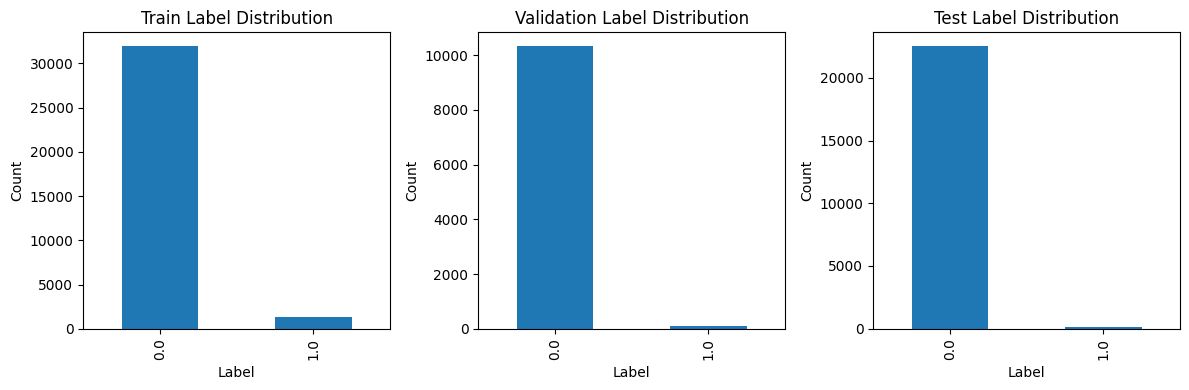

In [104]:
import matplotlib.pyplot as plt

# 計算各資料集的標籤分佈
train_counts = pd.Series(train_ds.y.numpy()).value_counts()
val_counts   = pd.Series(val_ds.y.numpy()).value_counts()
test_counts  = pd.Series(test_ds.y.numpy()).value_counts()

# 畫圖
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, counts, title in zip(
    axes,
    [train_counts, val_counts, test_counts],
    ["Train", "Validation", "Test"]
):
    counts.plot(kind='bar', ax=ax)
    ax.set_title(f"{title} Label Distribution")
    ax.set_xlabel("Label")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


In [105]:
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# 取出標籤（假設 train_ds.y 是 0/1 的 torch.tensor）
y = train_ds.y.cpu().numpy()
assert set(np.unique(y)).issubset({0,1}), "train_ds 應只有 0/1 標籤"

num_pos = int((y == 1).sum())
num_neg = int((y == 0).sum())
p_target = 0.15 # 你可以之後調 0.2~0.35

# 權重：讓期望抽樣比例 ≈ p_target
w_pos = p_target / max(num_pos, 1)
w_neg = (1.0 - p_target) / max(num_neg, 1)
sample_weights = np.where(y == 1, w_pos, w_neg).astype(np.float64)
sample_weights = torch.from_numpy(sample_weights)

balanced_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # 每個 epoch 跑滿步數
    replacement=True
)

In [106]:
train_loader = DataLoader(
    train_ds,
    batch_size=512,         # 或你的 GPU 極限
    #sampler=balanced_sampler,
    shuffle=True,  # 如果不使用 sampler，則需要 shuffle
    num_workers=8,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(val_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True)

## Train Model

In [107]:
from src.model import FocalLoss, CNNLSTMModel
from torch.optim import AdamW

model = CNNLSTMModel(
    num_features=len(extended_feature_cols),
    cnn_out_channels=32,   # 32 → 64
    lstm_hidden_size=64,  # 64 → 128
    lstm_layers=2,         # 1 → 2
    dropout=0.5
)

criterion = FocalLoss(alpha=0.75, gamma=2.0)
# 如果改用 BCE：
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.2], device=device))

optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

In [108]:
import math

steps_per_epoch = len(train_loader)
max_epochs = 30
total_steps = steps_per_epoch * max_epochs
warmup_steps = max(1, int(total_steps * 0.05))

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    progress = (current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
    return 0.1 + 0.9 * cosine  # 下界 0.1×

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


In [109]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

log = train_loop(
    model, train_loader, val_loader,
    log_interval=25,
    device=device,
    num_epochs=20,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    save_interval=4,
    #save_path='model/0814_0457'
)

Model moved to cuda
[Epoch 1/20] Step 0/64 - Loss: 0.0442
[Epoch 1/20] Step 25/64 - Loss: 0.0429
[Epoch 1/20] Step 50/64 - Loss: 0.0406
🔁 Epoch 1 finished. Avg Train Loss: 0.0417


Testing: 100%|██████████| 11/11 [00:01<00:00, 10.52it/s]

✅ avg_loss: 0.0339 | AUC-PR: 0.0080 | baseline: 0.0096 | uplift: 0.83x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000
Best model saved at epoch 1 with AUC-PR 0.0080


[Epoch 2/20] Step 0/64 - Loss: 0.0383
[Epoch 2/20] Step 25/64 - Loss: 0.0228
[Epoch 2/20] Step 50/64 - Loss: 0.0228
🔁 Epoch 2 finished. Avg Train Loss: 0.0289


Testing: 100%|██████████| 11/11 [00:01<00:00, 10.39it/s]

✅ avg_loss: 0.0111 | AUC-PR: 0.0062 | baseline: 0.0096 | uplift: 0.65x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000


[Epoch 3/20] Step 0/64 - Loss: 0.0247
[Epoch 3/20] Step 25/64 - Loss: 0.0235
[Epoch 3/20] Step 50/64 - Loss: 0.0201
🔁 Epoch 3 finished. Avg Train Loss: 0.0205


Testing: 100%|██████████| 11/11 [00:01<00:00, 10.40it/s]

✅ avg_loss: 0.0127 | AUC-PR: 0.0064 | baseline: 0.0096 | uplift: 0.67x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000


[Epoch 4/20] Step 0/64 - Loss: 0.0148
[Epoch 4/20] Step 25/64 - Loss: 0.0136
[Epoch 4/20] Step 50/64 - Loss: 0.0153
🔁 Epoch 4 finished. Avg Train Loss: 0.0177


Testing: 100%|██████████| 11/11 [00:01<00:00, 10.54it/s]


✅ avg_loss: 0.0117 | AUC-PR: 0.0067 | baseline: 0.0096 | uplift: 0.70x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000
[Epoch 5/20] Step 0/64 - Loss: 0.0149
[Epoch 5/20] Step 25/64 - Loss: 0.0177
[Epoch 5/20] Step 50/64 - Loss: 0.0113
🔁 Epoch 5 finished. Avg Train Loss: 0.0159


Testing: 100%|██████████| 11/11 [00:01<00:00, 10.56it/s]

✅ avg_loss: 0.0162 | AUC-PR: 0.0067 | baseline: 0.0096 | uplift: 0.70x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000


[Epoch 6/20] Step 0/64 - Loss: 0.0151
[Epoch 6/20] Step 25/64 - Loss: 0.0232
[Epoch 6/20] Step 50/64 - Loss: 0.0132
🔁 Epoch 6 finished. Avg Train Loss: 0.0160


Testing: 100%|██████████| 11/11 [00:01<00:00, 10.39it/s]

✅ avg_loss: 0.0134 | AUC-PR: 0.0068 | baseline: 0.0096 | uplift: 0.71x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000


[Epoch 7/20] Step 0/64 - Loss: 0.0191
[Epoch 7/20] Step 25/64 - Loss: 0.0217
[Epoch 7/20] Step 50/64 - Loss: 0.0149
🔁 Epoch 7 finished. Avg Train Loss: 0.0149


Testing: 100%|██████████| 11/11 [00:01<00:00, 10.65it/s]

✅ avg_loss: 0.0155 | AUC-PR: 0.0070 | baseline: 0.0096 | uplift: 0.73x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000


[Epoch 8/20] Step 0/64 - Loss: 0.0132
[Epoch 8/20] Step 25/64 - Loss: 0.0122
[Epoch 8/20] Step 50/64 - Loss: 0.0126
🔁 Epoch 8 finished. Avg Train Loss: 0.0141


Testing: 100%|██████████| 11/11 [00:01<00:00, 10.53it/s]

✅ avg_loss: 0.0176 | AUC-PR: 0.0068 | baseline: 0.0096 | uplift: 0.71x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000


[Epoch 9/20] Step 0/64 - Loss: 0.0170
[Epoch 9/20] Step 25/64 - Loss: 0.0110
[Epoch 9/20] Step 50/64 - Loss: 0.0130
🔁 Epoch 9 finished. Avg Train Loss: 0.0127


Testing: 100%|██████████| 11/11 [00:01<00:00, 10.42it/s]

✅ avg_loss: 0.0192 | AUC-PR: 0.0073 | baseline: 0.0096 | uplift: 0.76x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000


[Epoch 10/20] Step 0/64 - Loss: 0.0114
[Epoch 10/20] Step 25/64 - Loss: 0.0120
[Epoch 10/20] Step 50/64 - Loss: 0.0131
🔁 Epoch 10 finished. Avg Train Loss: 0.0135


Testing: 100%|██████████| 11/11 [00:01<00:00, 10.48it/s]

✅ avg_loss: 0.0208 | AUC-PR: 0.0069 | baseline: 0.0096 | uplift: 0.71x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000


[Epoch 11/20] Step 0/64 - Loss: 0.0125
[Epoch 11/20] Step 25/64 - Loss: 0.0105
[Epoch 11/20] Step 50/64 - Loss: 0.0098
🔁 Epoch 11 finished. Avg Train Loss: 0.0123


Testing: 100%|██████████| 11/11 [00:01<00:00, 10.56it/s]

✅ avg_loss: 0.0212 | AUC-PR: 0.0071 | baseline: 0.0096 | uplift: 0.74x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000


[Epoch 12/20] Step 0/64 - Loss: 0.0112
[Epoch 12/20] Step 25/64 - Loss: 0.0108
[Epoch 12/20] Step 50/64 - Loss: 0.0144
🔁 Epoch 12 finished. Avg Train Loss: 0.0120


Testing: 100%|██████████| 11/11 [00:01<00:00, 10.59it/s]

✅ avg_loss: 0.0213 | AUC-PR: 0.0069 | baseline: 0.0096 | uplift: 0.71x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000


[Epoch 13/20] Step 0/64 - Loss: 0.0191
[Epoch 13/20] Step 25/64 - Loss: 0.0104
[Epoch 13/20] Step 50/64 - Loss: 0.0083
🔁 Epoch 13 finished. Avg Train Loss: 0.0110


Testing: 100%|██████████| 11/11 [00:01<00:00, 10.23it/s]

✅ avg_loss: 0.0208 | AUC-PR: 0.0070 | baseline: 0.0096 | uplift: 0.73x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000


[Epoch 14/20] Step 0/64 - Loss: 0.0078
[Epoch 14/20] Step 25/64 - Loss: 0.0084
[Epoch 14/20] Step 50/64 - Loss: 0.0117
🔁 Epoch 14 finished. Avg Train Loss: 0.0103


Testing: 100%|██████████| 11/11 [00:01<00:00, 10.57it/s]


✅ avg_loss: 0.0214 | AUC-PR: 0.0071 | baseline: 0.0096 | uplift: 0.74x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000
[Epoch 15/20] Step 0/64 - Loss: 0.0084
[Epoch 15/20] Step 25/64 - Loss: 0.0143
[Epoch 15/20] Step 50/64 - Loss: 0.0126
🔁 Epoch 15 finished. Avg Train Loss: 0.0119


Testing: 100%|██████████| 11/11 [00:01<00:00, 10.31it/s]

✅ avg_loss: 0.0200 | AUC-PR: 0.0071 | baseline: 0.0096 | uplift: 0.74x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000


[Epoch 16/20] Step 0/64 - Loss: 0.0083
[Epoch 16/20] Step 25/64 - Loss: 0.0092
[Epoch 16/20] Step 50/64 - Loss: 0.0105
🔁 Epoch 16 finished. Avg Train Loss: 0.0102


Testing: 100%|██████████| 11/11 [00:01<00:00, 10.42it/s]


✅ avg_loss: 0.0196 | AUC-PR: 0.0071 | baseline: 0.0096 | uplift: 0.74x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000
[Epoch 17/20] Step 0/64 - Loss: 0.0081
[Epoch 17/20] Step 25/64 - Loss: 0.0129
[Epoch 17/20] Step 50/64 - Loss: 0.0133
🔁 Epoch 17 finished. Avg Train Loss: 0.0101


Testing: 100%|██████████| 11/11 [00:01<00:00, 10.44it/s]

✅ avg_loss: 0.0213 | AUC-PR: 0.0070 | baseline: 0.0096 | uplift: 0.73x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000


[Epoch 18/20] Step 0/64 - Loss: 0.0095
[Epoch 18/20] Step 25/64 - Loss: 0.0107
[Epoch 18/20] Step 50/64 - Loss: 0.0083
🔁 Epoch 18 finished. Avg Train Loss: 0.0091


Testing: 100%|██████████| 11/11 [00:01<00:00, 10.57it/s]

✅ avg_loss: 0.0220 | AUC-PR: 0.0072 | baseline: 0.0096 | uplift: 0.75x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000


[Epoch 19/20] Step 0/64 - Loss: 0.0090
[Epoch 19/20] Step 25/64 - Loss: 0.0086
[Epoch 19/20] Step 50/64 - Loss: 0.0073
🔁 Epoch 19 finished. Avg Train Loss: 0.0093


Testing: 100%|██████████| 11/11 [00:01<00:00, 10.36it/s]

✅ avg_loss: 0.0232 | AUC-PR: 0.0072 | baseline: 0.0096 | uplift: 0.75x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000


[Epoch 20/20] Step 0/64 - Loss: 0.0078
[Epoch 20/20] Step 25/64 - Loss: 0.0094
[Epoch 20/20] Step 50/64 - Loss: 0.0085
🔁 Epoch 20 finished. Avg Train Loss: 0.0091


Testing: 100%|██████████| 11/11 [00:01<00:00, 10.20it/s]

✅ avg_loss: 0.0232 | AUC-PR: 0.0073 | baseline: 0.0096 | uplift: 0.76x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000
🏁 Training completed.


In [110]:
log = pd.read_csv('model/0814_2150/training_log.csv')

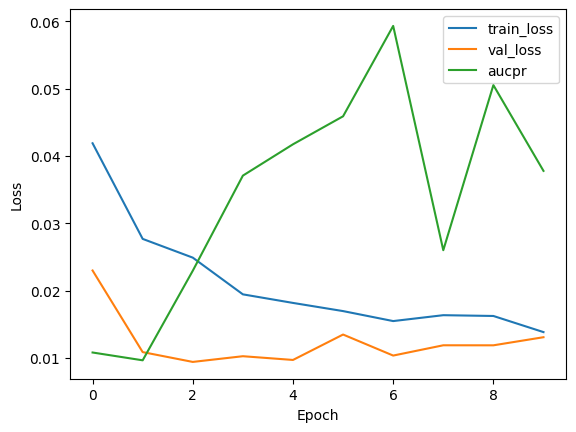

In [111]:
visualize_log(log)

### Model Evaluation

In [112]:
model.load_state_dict(torch.load(r'model/0814_2150/best_model.pth', weights_only=True))

<All keys matched successfully>

In [113]:
# 評估 train 分佈：不用 sampler、不shuffle
train_loader_eval = DataLoader(
    train_ds, batch_size=512, shuffle=False, num_workers=8, pin_memory=True
)


In [114]:
train_trues, train_outputs, train_loss= test_loop(model, train_loader_eval, criterion=criterion)


Testing: 100%|██████████| 65/65 [00:01<00:00, 48.99it/s]


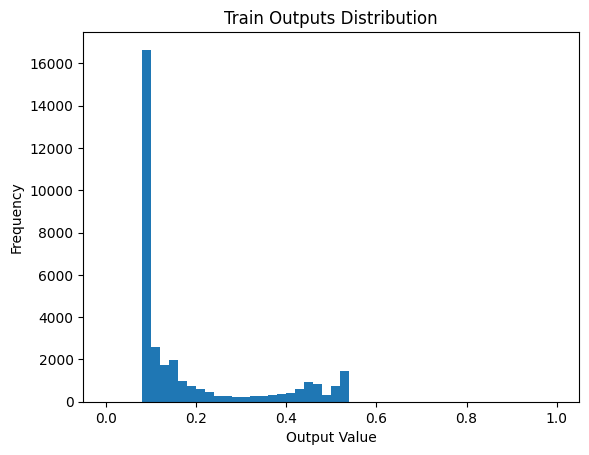

In [115]:
plot_outputs_distribution(train_outputs, "Train Outputs Distribution")

In [116]:
import plotly.express as px
df = pd.DataFrame(
    {
        "scores": train_outputs,
        "labels": train_trues
    }
)
px.histogram(df, x="scores", color="labels", barmode="stack", histnorm="probability", title="Train Outputs Distribution")

Performance on Training Set:
Train Loss: 0.017985676929283028
              precision    recall  f1-score   support

      Normal       0.99      0.84      0.91     31923
     Failure       0.16      0.76      0.27      1320

    accuracy                           0.84     33243
   macro avg       0.58      0.80      0.59     33243
weighted avg       0.96      0.84      0.88     33243

[[26798  5125]
 [  322   998]]
ROC AUC: 0.9094


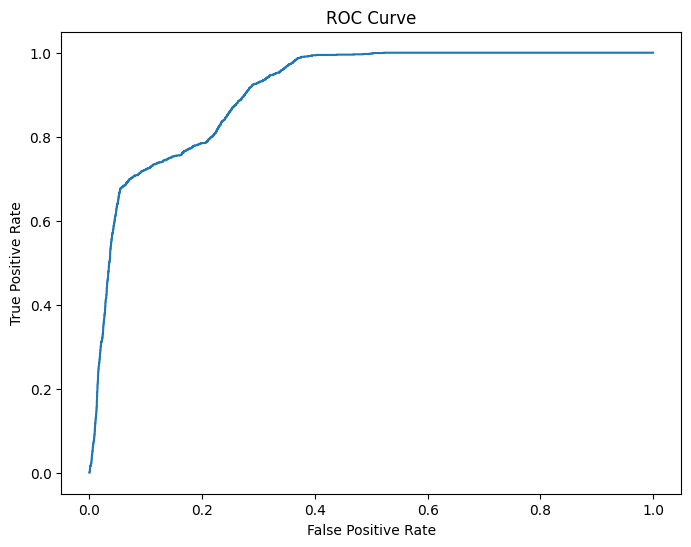

In [117]:
train_predictions = (train_outputs > 0.35).astype(int)

print("Performance on Training Set:")
print("Train Loss:", train_loss)

generate_report(train_trues, train_predictions, train_outputs)

In [118]:
from sklearn.linear_model import LogisticRegression
from src.train import get_logits_and_labels

val_logits, val_labels = get_logits_and_labels(model, val_loader)
test_logits, test_labels = get_logits_and_labels(model, test_loader)
val_scores = torch.sigmoid(torch.tensor(val_logits)).numpy()
test_scores = torch.sigmoid(torch.tensor(test_logits)).numpy()

# === 2. Platt scaling (logistic regression) ===
platt = LogisticRegression(solver='lbfgs', class_weight='balanced')
platt.fit(val_logits.reshape(-1, 1), val_labels)  # 強調正樣本

# === 3. 校準分數 ===
val_probs_calibrated = platt.predict_proba(val_logits.reshape(-1, 1))[:, 1]
test_probs_calibrated = platt.predict_proba(test_logits.reshape(-1, 1))[:, 1]

# === 4. 在 val 上找最佳門檻 ===
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(val_labels, val_probs_calibrated)

target_recall = 0.8
best_idx = next(i for i,r in enumerate(recall) if r < target_recall) - 1
best_threshold = thresholds[best_idx]
print(f"Threshold for recall ≥ {target_recall}: {best_threshold:.4f}, Precision={precision[best_idx]:.3f}")

# === 5. 在 test set 上套用門檻 ===
test_preds = (test_probs_calibrated >= best_threshold).astype(int)
val_preds = (val_probs_calibrated >= best_threshold).astype(int)

Threshold for recall ≥ 0.8: 0.7791, Precision=0.064


In [119]:
import plotly.express as px
df = pd.DataFrame(
    {
        "scores": val_probs_calibrated,
        "labels": val_labels
    }
)
px.histogram(df, x="scores", color="labels", barmode="stack", histnorm="probability", title="Validation Outputs Distribution")

Performance on Validation Set:
              precision    recall  f1-score   support

      Normal       1.00      0.89      0.94     10318
     Failure       0.06      0.80      0.12       100

    accuracy                           0.89     10418
   macro avg       0.53      0.84      0.53     10418
weighted avg       0.99      0.89      0.93     10418

[[9152 1166]
 [  20   80]]
ROC AUC: 0.9303


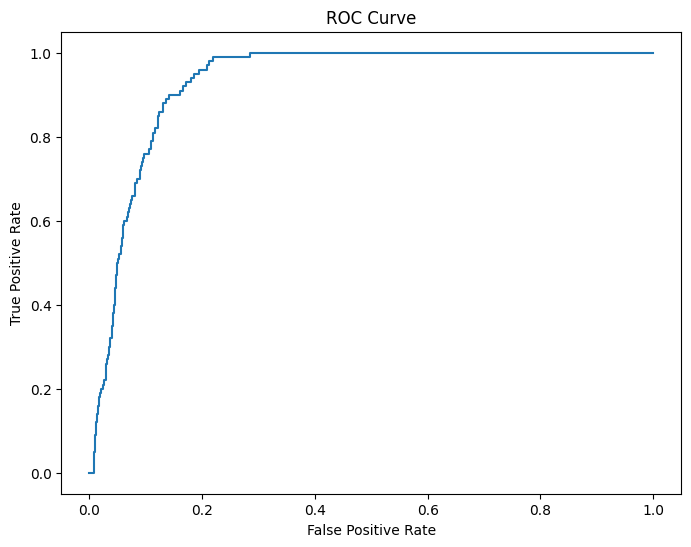

In [120]:
print("Performance on Validation Set:")
generate_report(val_labels, val_preds, val_probs_calibrated,)

Performance on Test Set:
              precision    recall  f1-score   support

      Normal       1.00      0.89      0.94     22497
     Failure       0.03      0.72      0.06       120

    accuracy                           0.89     22617
   macro avg       0.52      0.80      0.50     22617
weighted avg       0.99      0.89      0.94     22617

[[20034  2463]
 [   34    86]]
ROC AUC: 0.8480


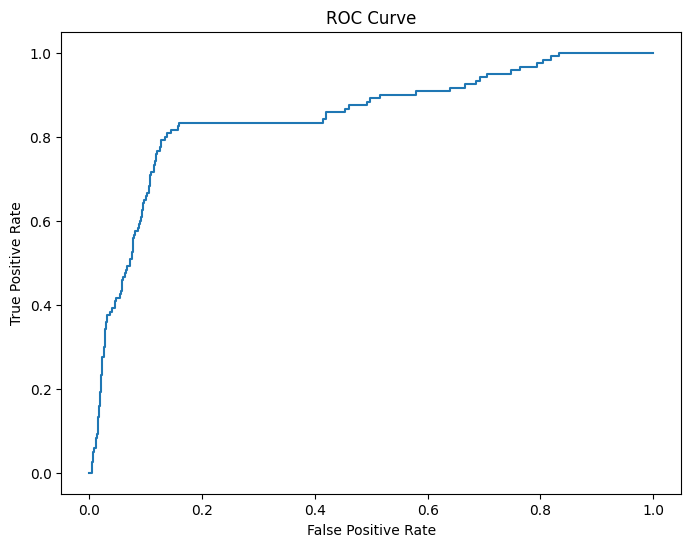

In [121]:
print("Performance on Test Set:")
generate_report(test_labels, test_preds, test_probs_calibrated)

In [122]:
import plotly.express as px
df = pd.DataFrame(
    {
        "scores": test_probs_calibrated,
        "labels": test_labels
    }
)
px.histogram(df, x="scores", color="labels", barmode="stack", histnorm="probability", title="Test Outputs Distribution")

In [123]:
from importlib import reload
import src.dataset_metadata as dm
reload(dm)

InverterTimeSeriesDataset = dm.InverterTimeSeriesDataset_metadata
PositiveInverterTimeSeriesDataset = dm.PositiveInverterTimeSeriesDataset_metadata
NegativeInverterTimeSeriesDataset = dm.NegativeInverterTimeSeriesDataset_metadata
combine_dataset = dm.combine_dataset_metadata

In [ ]:
window_size = 336
normal_stride = 12
positive_sample_stride = 2

positive_ds = PositiveInverterTimeSeriesDataset.from_dataframe(
    train_df, extended_feature_cols, window_size=window_size, stride=positive_sample_stride
)
negative_ds = NegativeInverterTimeSeriesDataset.from_dataframe(
    train_df, extended_feature_cols, window_size=window_size, stride=normal_stride
)
train_ds = combine_dataset([positive_ds, negative_ds])

val_ds  = InverterTimeSeriesDataset.from_dataframe(
    val_df,  extended_feature_cols, window_size=window_size, stride=normal_stride
)
test_ds = InverterTimeSeriesDataset.from_dataframe(
    test_df, extended_feature_cols, window_size=window_size, stride=normal_stride
)


print(type(val_ds))                   # should be InverterTimeSeriesDataset_metadata
print(hasattr(val_ds, "meta_data"))   # should be True
print(len(val_ds), len(val_ds.meta_data))  # lengths should match


In [124]:
from torch.utils.data import DataLoader
pin = (next(model.parameters()).device.type == "cuda")

val_loader  = DataLoader(val_ds,  batch_size=1024, shuffle=False, num_workers=0, pin_memory=pin)
test_loader = DataLoader(test_ds, batch_size=1024, shuffle=False, num_workers=0, pin_memory=pin)


from src.train import get_logits_and_labels

val_logits,  val_labels  = get_logits_and_labels(model, val_loader)  # make sure helper uses model's device
test_logits, test_labels = get_logits_and_labels(model, test_loader)


val_scores  = torch.sigmoid(torch.tensor(val_logits)).numpy()
test_scores = torch.sigmoid(torch.tensor(test_logits)).numpy()


assert len(val_scores)  == len(val_ds.meta_data)
assert len(test_scores) == len(test_ds.meta_data)
assert len(val_scores)  == len(val_labels)
assert len(test_scores) == len(test_labels)

In [125]:
def _is_sorted(ds, time_col="end"):
    m = ds.meta_data.copy()
    m[time_col] = pd.to_datetime(m[time_col], utc=True, errors="coerce")
    # within each device, time must be non-decreasing
    return m.groupby("device")[time_col].apply(lambda s: s.is_monotonic_increasing).all()

print("val sorted?",  _is_sorted(val_ds))
print("test sorted?", _is_sorted(test_ds))


val sorted? True
test sorted? True


In [126]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # <<< important


CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv1d(21, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (lstm): LSTM(32, 64, num_layers=2, batch_first=True, dropout=0.5)
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [127]:
from src.train import get_logits_and_labels  # your existing helper
import torch
import numpy as np


val_logits,  val_labels  = get_logits_and_labels(model, val_loader)
test_logits, test_labels = get_logits_and_labels(model, test_loader)

val_scores  = torch.sigmoid(torch.tensor(val_logits)).numpy()
test_scores = torch.sigmoid(torch.tensor(test_logits)).numpy()

# Sanity checks:
assert len(val_scores)  == len(val_ds.meta_data),  f"val size mismatch: {len(val_scores)} vs {len(val_ds.meta_data)}"
assert len(test_scores) == len(test_ds.meta_data), f"test size mismatch: {len(test_scores)} vs {len(test_ds.meta_data)}"
assert len(val_scores)  == len(val_labels),        "val labels mismatch"
assert len(test_scores) == len(test_labels),       "test labels mismatch"


In [128]:
from src.post_process import *

In [129]:
val_scores  = val_probs_calibrated
test_scores = test_probs_calibrated

val_groups  = val_ds.meta_data['device'].to_numpy()
test_groups = test_ds.meta_data['device'].to_numpy()

[VAL] kept runs: 116, removed short blips: 380
[TEST] kept runs: 147, removed short blips: 394
Performance on Validation (smoothed, calibrated):
              precision    recall  f1-score   support

      Normal       1.00      0.94      0.97     10318
     Failure       0.10      0.68      0.17       100

    accuracy                           0.94     10418
   macro avg       0.55      0.81      0.57     10418
weighted avg       0.99      0.94      0.96     10418

[[9698  620]
 [  32   68]]
ROC AUC: 0.9303
Performance on Test (smoothed, calibrated):
              precision    recall  f1-score   support

      Normal       1.00      0.92      0.95     22497
     Failure       0.04      0.65      0.07       120

    accuracy                           0.91     22617
   macro avg       0.52      0.78      0.51     22617
weighted avg       0.99      0.91      0.95     22617

[[20593  1904]
 [   42    78]]
ROC AUC: 0.8480


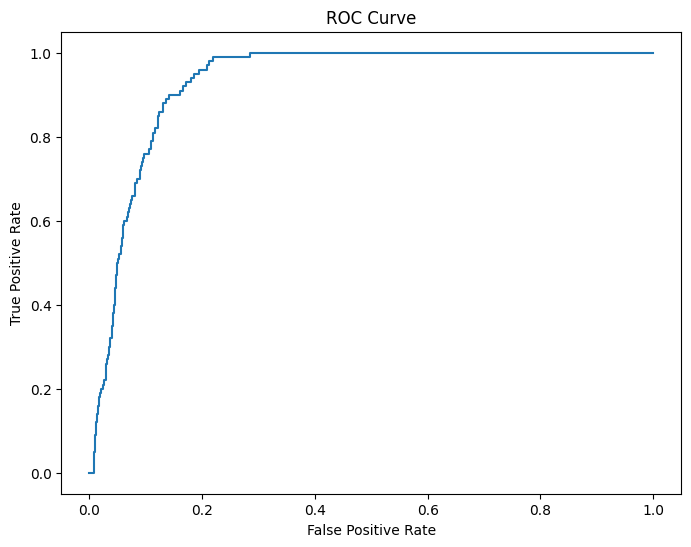

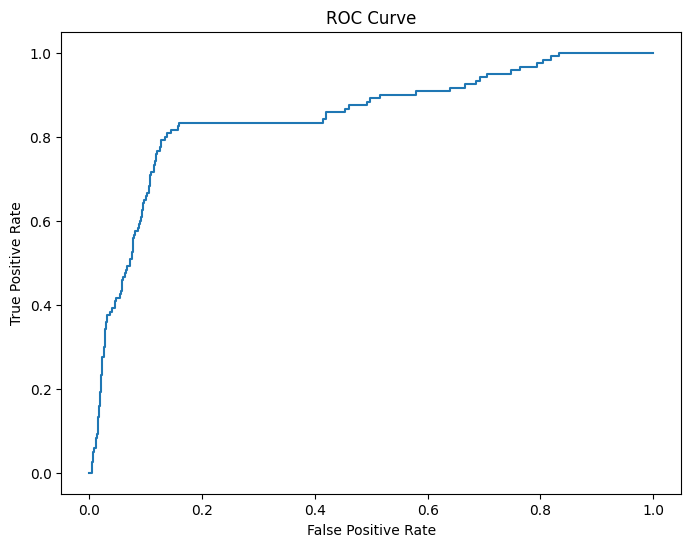

In [130]:

val_bin  = (val_scores  >= best_threshold).astype(np.uint8)
test_bin = (test_scores >= best_threshold).astype(np.uint8)


val_bin_smooth,  val_kept,  val_noise  = smooth_by_consecutive(val_bin,  group_ids=val_groups,  min_consecutive=3)
test_bin_smooth, test_kept, test_noise = smooth_by_consecutive(test_bin, group_ids=test_groups, min_consecutive=3)

print(f"[VAL] kept runs: {len(val_kept)}, removed short blips: {len(val_noise)}")
print(f"[TEST] kept runs: {len(test_kept)}, removed short blips: {len(test_noise)}")

from src.train import generate_report
print("Performance on Validation (smoothed, calibrated):")
generate_report(val_labels,  val_bin_smooth,  val_scores)
print("Performance on Test (smoothed, calibrated):")
generate_report(test_labels, test_bin_smooth, test_scores)
